In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Разбивка по годам 

## Знакомство с данными

In [81]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])
df_orders.head()

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09,2014
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07,2014
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03,2014
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01,2014
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04,2014


In [82]:
df_customers = pd.read_csv('customers.csv')
df_customers.rename(columns = {'id':'customer_id'}, inplace=True)
df_customers.head()

,customer_id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [83]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')
df_merge.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city
3265,102638,2017-12-29,First,MC-17845,6.030,2017-12,2017,Michael Chen,Consumer,Mississippi,Jackson
3967,160108,2016-12-08,Standard,AG-10900,1085.870,2016-12,2016,Arthur Gainer,Consumer,Arizona,Tucson
1570,125115,2017-04-10,Same Day,RD-19930,106.104,2017-04,2017,Russell D'Ascenzo,Consumer,Texas,Austin
4149,128027,2015-09-14,Second,CM-12385,269.490,2015-09,2015,Christopher Martinez,Consumer,Georgia,Atlanta
3602,158876,2017-11-19,Second,AB-10150,138.696,2017-11,2017,Aimee Bixby,Consumer,New York,Long Beach


In [84]:
df_first = df_merge.groupby('customer_id')['order_year'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']
df_first.sample(5)

,customer_id,first_order
141,CD-12790,2014
174,CS-12175,2014
293,GA-14725,2014
748,TG-21640,2014
766,TS-21505,2014


In [85]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')
df_full.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
3439,163447,2014-12-27,Standard,TB-21190,767.214,2014-12,2014,Thomas Brumley,Home Office,Arkansas,Fayetteville,2014
1059,144099,2015-11-29,Same Day,PO-19195,4.304,2015-11,2015,Phillina Ober,Home Office,Illinois,Naperville,2014
1230,152646,2016-11-21,Standard,TH-21235,32.400,2016-11,2016,Tiffany House,Corporate,Texas,Dallas,2014
153,102932,2016-09-19,Second,SD-20485,53.370,2016-09,2016,Shirley Daniels,Home Office,New York,New Rochelle,2014
4948,150924,2014-09-12,Second,PT-19090,5.180,2014-09,2014,Pete Takahito,Consumer,Texas,Houston,2014


In [86]:
df_users = df_full.groupby(['customer_id', 'segment', 'ship_mode', 'first_order', 'order_year'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()
df_users.rename(columns={'sales': 'sales_sum', 'id': 'order_counts'}, inplace=True)
df_users.head(5)

,customer_id,segment,ship_mode,first_order,order_year,sales_sum,order_counts
0,AA-10315,Consumer,First,2014,2015,26.960,1
1,AA-10315,Consumer,Standard,2014,2014,756.048,2
2,AA-10315,Consumer,Standard,2014,2016,4406.072,1
3,AA-10315,Consumer,Standard,2014,2017,374.480,1
4,AA-10375,Consumer,First,2014,2015,178.370,1


In [87]:
def get_crosstab(df, value_column):
    df_crosstab = pd.crosstab(df.customer_id, df.order_year, values=df[value_column], aggfunc=sum)\
        .reset_index()
    df_crosstab = pd.merge(df_crosstab, df_first, how='inner', on='customer_id')
    del df_crosstab['customer_id']
    return df_crosstab

In [88]:
df_test = get_crosstab(df_users, 'order_counts')

In [89]:
df_test.head(5)

,2014,2015,2016,2017,first_order
0,2.0,1.0,1.0,1.0,2014
1,2.0,3.0,2.0,2.0,2014
2,1.0,NaN,2.0,1.0,2014
3,2.0,1.0,2.0,1.0,2014
4,2.0,NaN,1.0,NaN,2014


In [90]:
def get_retention(df):
    df_triangle = df.groupby(['first_order']).sum().reset_index()
    df_triangle['Base'] = np.diag(df_triangle.iloc[:,1:])
    df_retention = pd.DataFrame(df_triangle[['first_order', 'Base']])
    df_retention.columns = ['Cohort', 'Base']

    for col in df_triangle.columns[1:-1]:
        df_retention[col] = round(df_triangle[col] / df_triangle['Base'], 3)

    for i in range(2, len(df_retention.columns)):
        df_retention.iloc[i-1:, i] = None
        
    return df_retention

## Выводы

### Sales retention

In [91]:
get_retention(get_crosstab(df_users, 'sales_sum'))

,Cohort,Base,2014,2015,2016,2017
0,2014,484247.4981,1.0,0.754,0.939,1.101
1,2015,105388.4962,NaN,1.000,0.944,1.250
2,2016,54803.6200,NaN,NaN,1.000,1.111
3,2017,7511.8050,NaN,NaN,NaN,1.000


In [92]:
tmp = get_retention(get_crosstab(df_users, 'sales_sum'))

<AxesSubplot:>

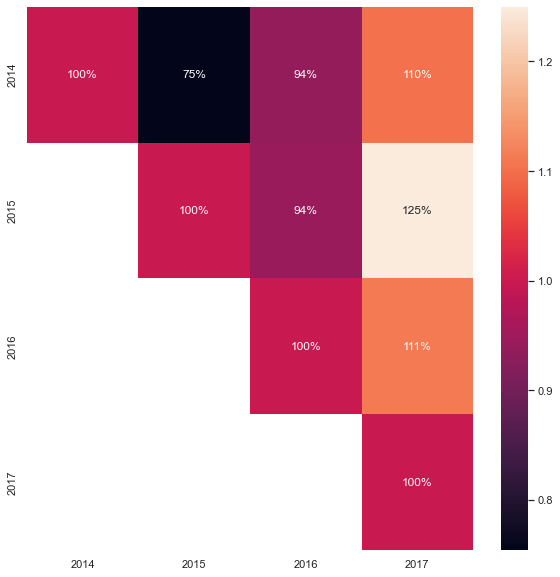

In [113]:
sns.set(style='white')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(tmp.iloc[:, 2:], annot=True, fmt='.0%', yticklabels=tmp['Cohort'], ax=ax)

### Transaction retention

In [13]:
get_retention(get_crosstab(df_users, 'order_counts'))

,Cohort,Base,2014,2015,2016,2017
0,2014,969.0,1.0,0.833,1.028,1.288
1,2015,231.0,NaN,1.000,0.931,1.268
2,2016,104.0,NaN,NaN,1.000,1.221
3,2017,19.0,NaN,NaN,NaN,1.000


### Sales retention by segment

In [14]:
for segment in df_users.segment.unique():
    print(f'\nSegment: {segment}')
    print(get_retention(get_crosstab(df_users[df_users.segment==segment], 'sales_sum')))


Segment: Consumer
  Cohort         Base  2014   2015   2016   2017
0   2014  266096.8126   1.0  0.789  0.818  0.906
1   2015   56590.8551   NaN  1.000  0.832  0.817
2   2016   32119.4550   NaN    NaN  1.000  1.229
3   2017    4985.0760   NaN    NaN    NaN  1.000

Segment: Home Office
  Cohort        Base  2014   2015   2016   2017
0   2014  89715.8118   1.0  0.616  0.874  1.296
1   2015  19942.1216   NaN  1.000  1.120  1.475
2   2016   4483.5420   NaN    NaN  1.000  2.905
3   2017    729.6480   NaN    NaN    NaN  1.000

Segment: Corporate
  Cohort         Base  2014   2015   2016   2017
0   2014  128434.8737   1.0  0.778  1.237  1.367
1   2015   28855.5195   NaN  1.000  1.043  1.944
2   2016   18200.6230   NaN    NaN  1.000  0.462
3   2017    1797.0810   NaN    NaN    NaN  1.000


### Sales retention by ship_mode

In [15]:
for ship_mode in df_users.ship_mode.unique():
    print(f'\nShip_mode: {ship_mode}')
    print(get_retention(get_crosstab(df_users[df_users.ship_mode==ship_mode], 'sales_sum')))


Ship_mode: First
  Cohort        Base  2014   2015   2016   2017
0   2014  59769.2645   1.0  0.997  1.010  1.590
1   2015   9644.0606   NaN  1.000  1.632  2.143
2   2016   6153.2850   NaN    NaN  1.000  3.814
3   2017    955.7840   NaN    NaN    NaN  1.000

Ship_mode: Standard
  Cohort         Base  2014   2015   2016   2017
0   2014  305621.3196   1.0  0.716  0.921  0.935
1   2015   65723.8550   NaN  1.000  0.791  1.142
2   2016   38855.4240   NaN    NaN  1.000  0.752
3   2017    5644.8960   NaN    NaN    NaN  1.000

Ship_mode: Second
  Cohort         Base  2014   2015   2016   2017
0   2014  101386.7800   1.0  0.642  0.811  1.105
1   2015   23970.2056   NaN  1.000  1.180  1.216
2   2016    9537.8710   NaN    NaN  1.000  0.697
3   2017     911.1250   NaN    NaN    NaN  1.000

Ship_mode: Same Day
  Cohort       Base  2014   2015   2016   2017
0   2014  17470.134   1.0  1.234  1.759  2.308
1   2015   6050.375   NaN  1.000  0.581  1.136
2   2016    257.040   NaN    NaN  1.000  6.163


### Transaction retention by segment

In [16]:
for segment in df_users.segment.unique():
    print(f'\nSegment: {segment}')
    print(get_retention(get_crosstab(df_users[df_users.segment==segment], 'order_counts')))


Segment: Consumer
  Cohort   Base  2014   2015   2016   2017
0   2014  524.0   1.0  0.817  0.954  1.265
1   2015  107.0   NaN  1.000  0.869  1.215
2   2016   58.0   NaN    NaN  1.000  1.207
3   2017   13.0   NaN    NaN    NaN  1.000

Segment: Home Office
  Cohort   Base  2014   2015   2016   2017
0   2014  158.0   1.0  0.899  1.095  1.405
1   2015   49.0   NaN  1.000  1.122  1.429
2   2016   14.0   NaN    NaN  1.000  1.786
3   2017    1.0   NaN    NaN    NaN  1.000

Segment: Corporate
  Cohort   Base  2014   2015   2016   2017
0   2014  287.0   1.0  0.826  1.125  1.265
1   2015   75.0   NaN  1.000  0.893  1.240
2   2016   32.0   NaN    NaN  1.000  1.000
3   2017    5.0   NaN    NaN    NaN  1.000


### Transaction retention by ship_mode

In [17]:
for ship_mode in df_users.ship_mode.unique():
    print(f'\nShip_mode: {ship_mode}')
    print(get_retention(get_crosstab(df_users[df_users.ship_mode==ship_mode], 'order_counts')))


Ship_mode: First
  Cohort   Base  2014   2015   2016   2017
0   2014  145.0   1.0  0.772  1.103  1.448
1   2015   31.0   NaN  1.000  1.194  1.516
2   2016   18.0   NaN    NaN  1.000  1.278
3   2017    4.0   NaN    NaN    NaN  1.000

Ship_mode: Standard
  Cohort   Base  2014   2015   2016   2017
0   2014  586.0   1.0  0.845  1.002  1.229
1   2015  141.0   NaN  1.000  0.943  1.284
2   2016   62.0   NaN    NaN  1.000  1.242
3   2017   12.0   NaN    NaN    NaN  1.000

Ship_mode: Second
  Cohort   Base  2014   2015   2016   2017
0   2014  190.0   1.0  0.826  0.995  1.311
1   2015   49.0   NaN  1.000  0.673  1.020
2   2016   22.0   NaN    NaN  1.000  1.000
3   2017    3.0   NaN    NaN    NaN  1.000

Ship_mode: Same Day
  Cohort  Base  2014   2015  2016   2017
0   2014  48.0   1.0  0.896  1.25  1.438
1   2015  10.0   NaN  1.000  1.20  1.500
2   2016   2.0   NaN    NaN  1.00  2.500


## Предподготовленный ответ из ноутбука
#### 1. Тотально sales и transaction ретеншены 2016 лучше 2015
#### 2. Но есть слабые когорты, где хуже: 
#### - Для sales-retention это:
    - Segment: Consumer, first order=2015
    - Ship_mode: Standard, first order=2015
#### - Для transaction-retention это:
    - Segment: Consumer, first order=2015
    - Segment: Corporate, first order=2015
    - Ship_mode: Standard, first order=2015
    - Ship_mode: Second, first order=2015


# Разбивка по месяцам

Уточнение контекста:
- С одной стороны в первоначальном ответе приводятся выводы относительно 2015 и 2016 года
- С другой стороны в условии сказано "Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году?"
- В датасете последняя информация относится к 2017 году, значит на дворе сейчас как минимум 2017 год и сравнивать нужно 2017 и 2016
- А раз сравнивать нужно последний год, то с разбивкой по году делать выоды о ретеншне не получится, нужно считать по месяцам


In [115]:
df_orders['order_month'].value_counts().sort_index()

2014-01     32
2014-02     28
2014-03     71
2014-04     66
2014-05     69
2014-06     66
2014-07     65
2014-08     72
2014-09    130
2014-10     78
2014-11    151
2014-12    141
2015-01     29
2015-02     36
2015-03     79
2015-04     72
2015-05     74
2015-06     68
2015-07     66
2015-08     68
2015-09    140
2015-10     87
2015-11    158
2015-12    161
2016-01     48
2016-02     45
2016-03     86
2016-04     89
2016-05    108
2016-06     97
2016-07     96
2016-08     90
2016-09    192
2016-10    105
2016-11    183
2016-12    176
2017-01     69
2017-02     53
2017-03    118
2017-04    116
2017-05    118
2017-06    133
2017-07    111
2017-08    111
2017-09    226
2017-10    147
2017-11    261
2017-12    224
Name: order_month, dtype: int64

In [116]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')
df_merge.sample(5)
assert df_merge.shape[0] == df_orders.shape[0]

In [117]:
df_first = df_merge.groupby('customer_id')['order_month'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']
df_first

,customer_id,first_order
0,AA-10315,2014-03
1,AA-10375,2014-04
2,AA-10480,2014-05
3,AA-10645,2014-06
4,AB-10015,2014-02
...,...,...
788,XP-21865,2014-01
789,YC-21895,2014-11
790,YS-21880,2015-01
791,ZC-21910,2014-10


In [118]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')
df_full

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09,2014,Dennis Kane,Consumer,Ohio,Marion,2014-09
1,131884,2015-12-06,Same Day,DK-13375,594.002,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion,2014-09
2,145065,2015-12-12,First,DK-13375,32.308,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion,2014-09
3,133046,2017-07-27,Second,DK-13375,297.990,2017-07,2017,Dennis Kane,Consumer,Ohio,Marion,2014-09
4,165099,2017-12-11,First,DK-13375,1.392,2017-12,2017,Dennis Kane,Consumer,Ohio,Marion,2014-09
...,...,...,...,...,...,...,...,...,...,...,...,...
5004,168193,2017-03-06,Second,RM-19750,98.350,2017-03,2017,Roland Murray,Consumer,New York,New York City,2017-03
5005,122140,2015-04-02,Standard,MO-17950,130.288,2015-04,2015,Michael Oakman,Consumer,Texas,Dallas,2015-04
5006,166233,2017-07-03,Standard,MO-17950,24.000,2017-07,2017,Michael Oakman,Consumer,Texas,Dallas,2015-04
5007,160150,2015-07-19,First,TS-21085,2.025,2015-07,2015,Thais Sissman,Consumer,Arizona,Phoenix,2015-07


In [119]:
df_users = df_full.groupby(['customer_id', 'segment', 'ship_mode', 'first_order', 'order_month'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()
df_users.rename(columns={'sales': 'sales_sum', 'id': 'order_counts'}, inplace=True)
df_users.head(5)

,customer_id,segment,ship_mode,first_order,order_month,sales_sum,order_counts
0,AA-10315,Consumer,First,2014-03,2015-10,26.960,1
1,AA-10315,Consumer,Standard,2014-03,2014-03,726.548,1
2,AA-10315,Consumer,Standard,2014-03,2014-09,29.500,1
3,AA-10315,Consumer,Standard,2014-03,2016-03,4406.072,1
4,AA-10315,Consumer,Standard,2014-03,2017-06,374.480,1


In [120]:
def get_crosstab_month(df, value_column):
    df_crosstab = pd.crosstab(df['customer_id'], df['order_month'], values=df[value_column], aggfunc=sum).reset_index()
    df_crosstab = pd.merge(df_crosstab, df_first, how='inner', on='customer_id')
    del df_crosstab['customer_id']
    return df_crosstab

In [121]:
df_test = get_crosstab_month(df_users, 'order_counts')

In [ ]:
df_test.head(5)

In [128]:
def get_retention_month(df):
    """Дополнительна модификация: месяцы в которых не было новых первых покупок все равно добавляет в матрицу"""
    df_triangle = df.groupby(['first_order']).sum().reset_index()
    
    # модификация - начало
    columns_with_value = df_triangle.columns[1:]
    row_empty_part = [0 for i in range(len(columns_with_value))]

    empty_rows = []
    for col in columns_with_value:
        if col not in df_triangle['first_order'].values:
            cur_row = [col] + row_empty_part
            empty_rows.append(cur_row)

    empty_rows = pd.DataFrame(empty_rows, columns=df_triangle.columns)
    df_triangle = df_triangle.append(empty_rows).sort_values(by='first_order').reset_index(drop=True)    
    # модификация - конец
    df_triangle['Base'] = np.diag(df_triangle.iloc[:,1:])
    df_retention = pd.DataFrame(df_triangle[['first_order', 'Base']])
    df_retention.columns = ['Cohort', 'Base']

    for col in df_triangle.columns[1:-1]:
        df_retention[col] = round(df_triangle[col] / df_triangle['Base'], 3)

    for i in range(2, len(df_retention.columns)):
        df_retention.iloc[i-1:, i] = None
        
    return df_retention

## Выводы

### Sales retention

In [134]:
df_sales_retention = get_retention_month(get_crosstab_month(df_users, 'sales_sum'))
df_sales_retention

,Cohort,Base,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,2014-01,14236.8950,1.0,0.016,0.000,0.103,0.003,0.000,0.008,0.064,...,0.196,0.014,0.111,0.138,0.057,0.025,0.567,0.144,0.864,0.047
1,2014-02,4294.6600,NaN,1.000,0.148,0.139,0.134,0.000,0.162,0.242,...,0.205,0.131,0.037,1.501,0.182,0.250,0.232,0.366,0.840,0.141
2,2014-03,55056.6990,NaN,NaN,1.000,0.028,0.046,0.060,0.056,0.000,...,0.070,0.056,0.087,0.104,0.057,0.055,0.087,0.045,0.158,0.111
3,2014-04,24707.1650,NaN,NaN,NaN,1.000,0.098,0.035,0.094,0.018,...,0.207,0.010,0.235,0.098,0.236,0.168,0.247,0.130,0.164,0.324
4,2014-05,18070.3410,NaN,NaN,NaN,NaN,1.000,0.093,0.103,0.036,...,0.007,0.059,0.118,0.263,0.139,0.037,0.184,0.305,0.642,0.127
5,2014-06,28735.8210,NaN,NaN,NaN,NaN,NaN,1.000,0.012,0.001,...,0.122,0.156,0.100,0.128,0.079,0.010,0.235,0.063,0.534,0.129
6,2014-07,25492.1410,NaN,NaN,NaN,NaN,NaN,NaN,1.000,0.086,...,0.039,0.265,0.143,0.175,0.035,0.195,0.094,0.312,0.232,0.199
7,2014-08,22634.6935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,...,0.042,0.039,0.116,0.123,0.129,0.108,0.076,0.168,0.189,0.355
8,2014-09,43648.8948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050,0.113,0.028,0.085,0.214,0.084,0.388,0.420,0.098,0.099
9,2014-10,20829.9950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.216,0.030,0.036,0.213,0.127,0.087,0.160,0.413,0.278,0.171


<AxesSubplot:>

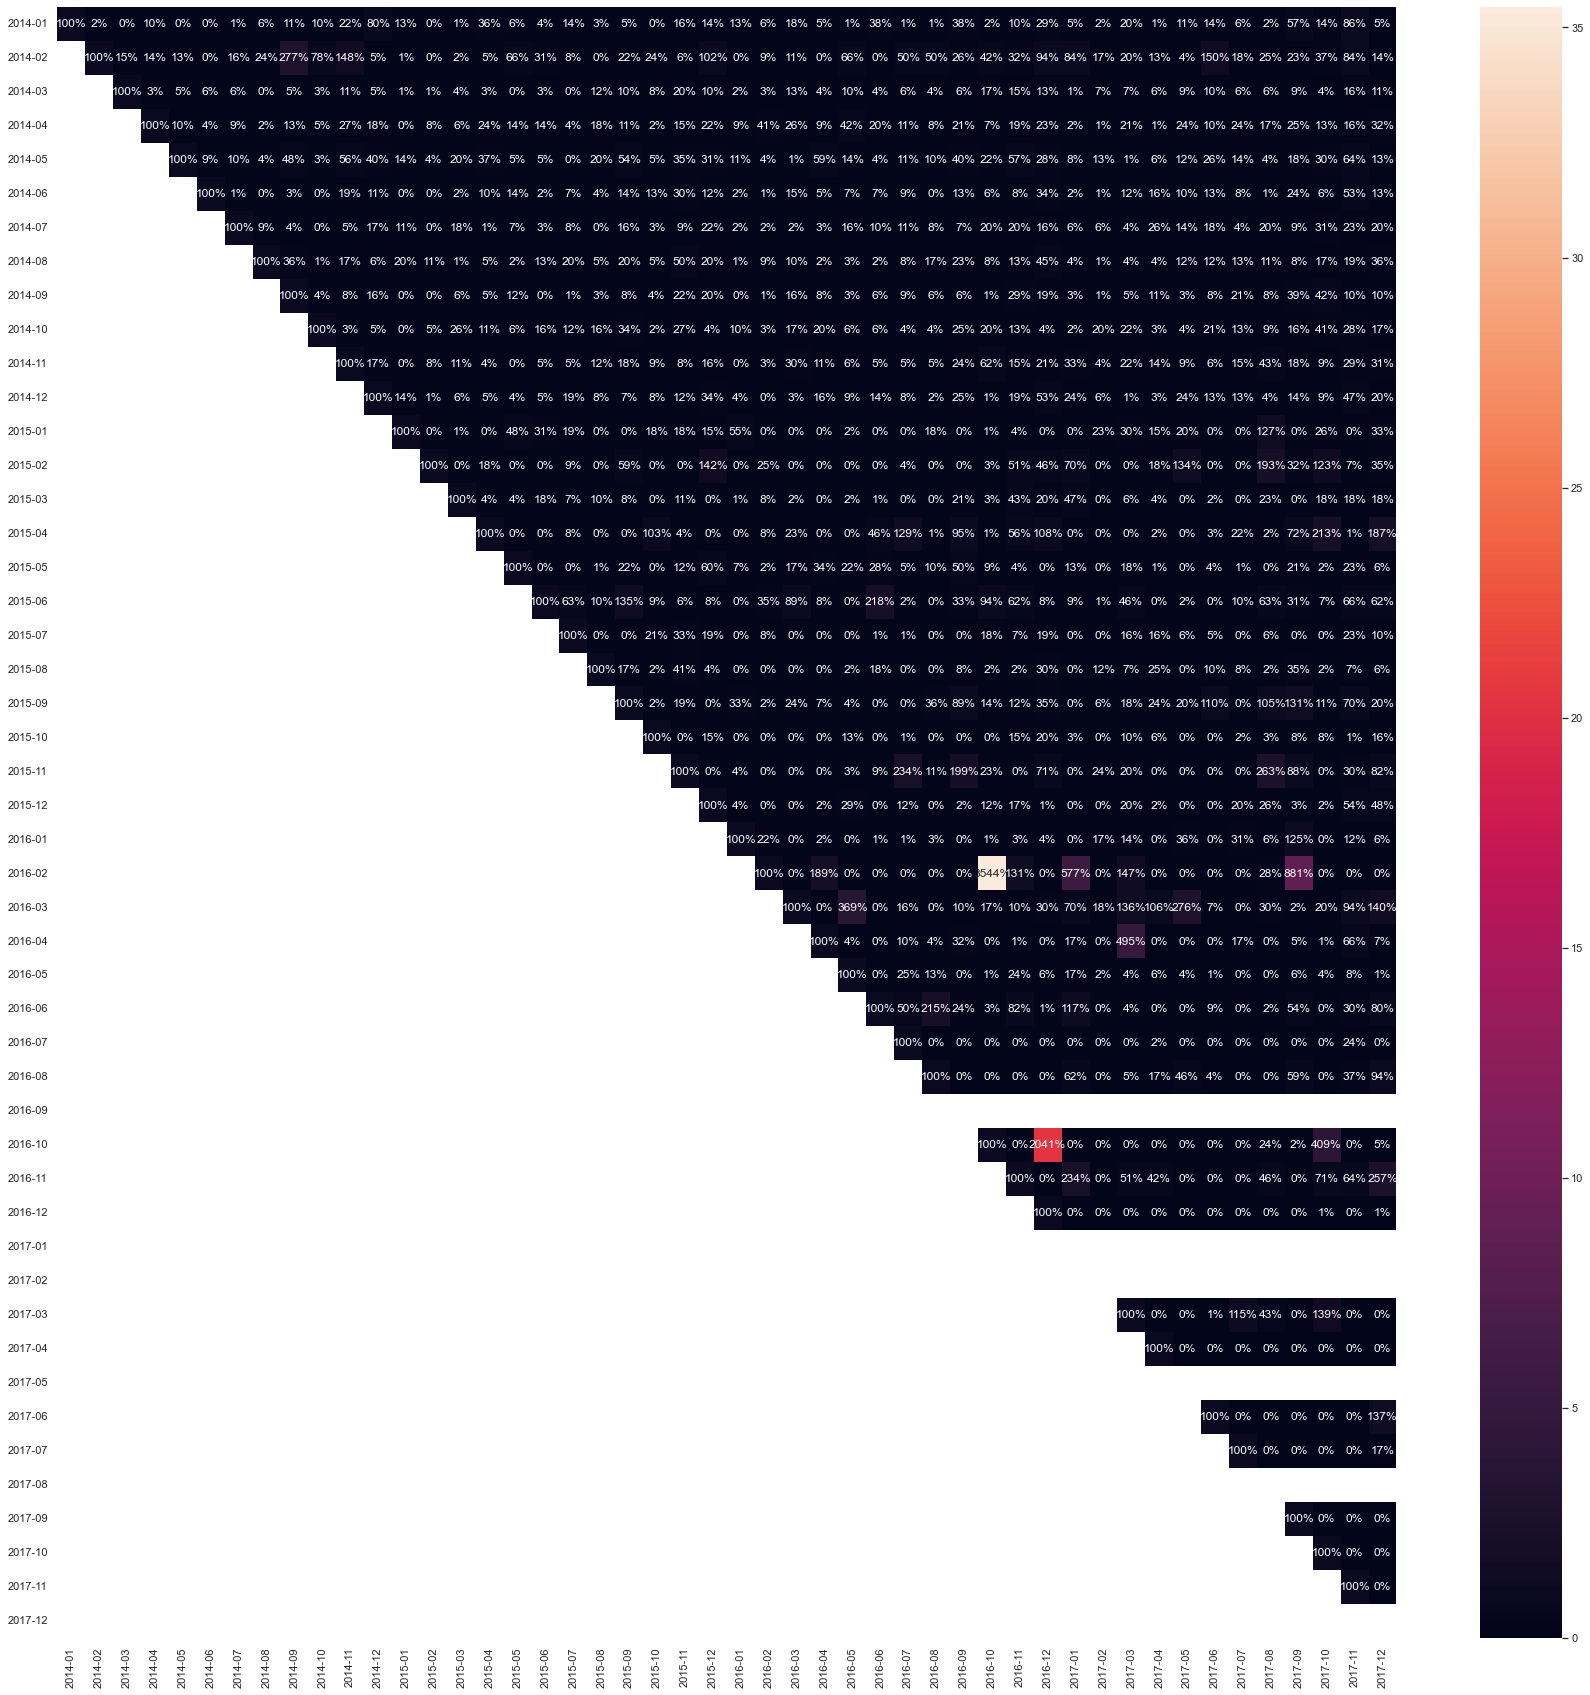

In [135]:
sns.set(style='white')
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_sales_retention.iloc[:, 2:], annot=True, fmt='.0%', yticklabels=df_sales_retention['Cohort'], ax=ax)

### Transaction retention

In [130]:
df_counts_retention = get_retention_month(get_crosstab_month(df_users, 'order_counts'))
df_counts_retention

,Cohort,Base,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,2014-01,32.0,1.0,0.125,0.000,0.062,0.062,0.000,0.062,0.125,...,0.188,0.125,0.156,0.125,0.031,0.094,0.281,0.312,0.406,0.219
1,2014-02,24.0,NaN,1.000,0.167,0.125,0.042,0.000,0.083,0.083,...,0.167,0.125,0.083,0.250,0.125,0.125,0.208,0.250,0.333,0.125
2,2014-03,67.0,NaN,NaN,1.000,0.075,0.045,0.119,0.104,0.000,...,0.104,0.179,0.209,0.149,0.179,0.104,0.328,0.134,0.313,0.269
3,2014-04,56.0,NaN,NaN,NaN,1.000,0.107,0.071,0.071,0.054,...,0.250,0.054,0.196,0.089,0.161,0.161,0.286,0.161,0.304,0.268
4,2014-05,57.0,NaN,NaN,NaN,NaN,1.000,0.088,0.088,0.070,...,0.053,0.088,0.070,0.246,0.158,0.105,0.333,0.158,0.368,0.175
5,2014-06,49.0,NaN,NaN,NaN,NaN,NaN,1.000,0.020,0.041,...,0.082,0.122,0.184,0.204,0.122,0.061,0.265,0.143,0.327,0.224
6,2014-07,44.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000,0.136,...,0.114,0.159,0.182,0.273,0.091,0.159,0.273,0.227,0.409,0.295
7,2014-08,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,...,0.059,0.157,0.137,0.176,0.196,0.157,0.196,0.275,0.314,0.216
8,2014-09,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.123,0.123,0.110,0.164,0.192,0.123,0.301,0.137,0.233,0.178
9,2014-10,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.136,0.114,0.159,0.273,0.205,0.091,0.250,0.159,0.386,0.341


<AxesSubplot:>

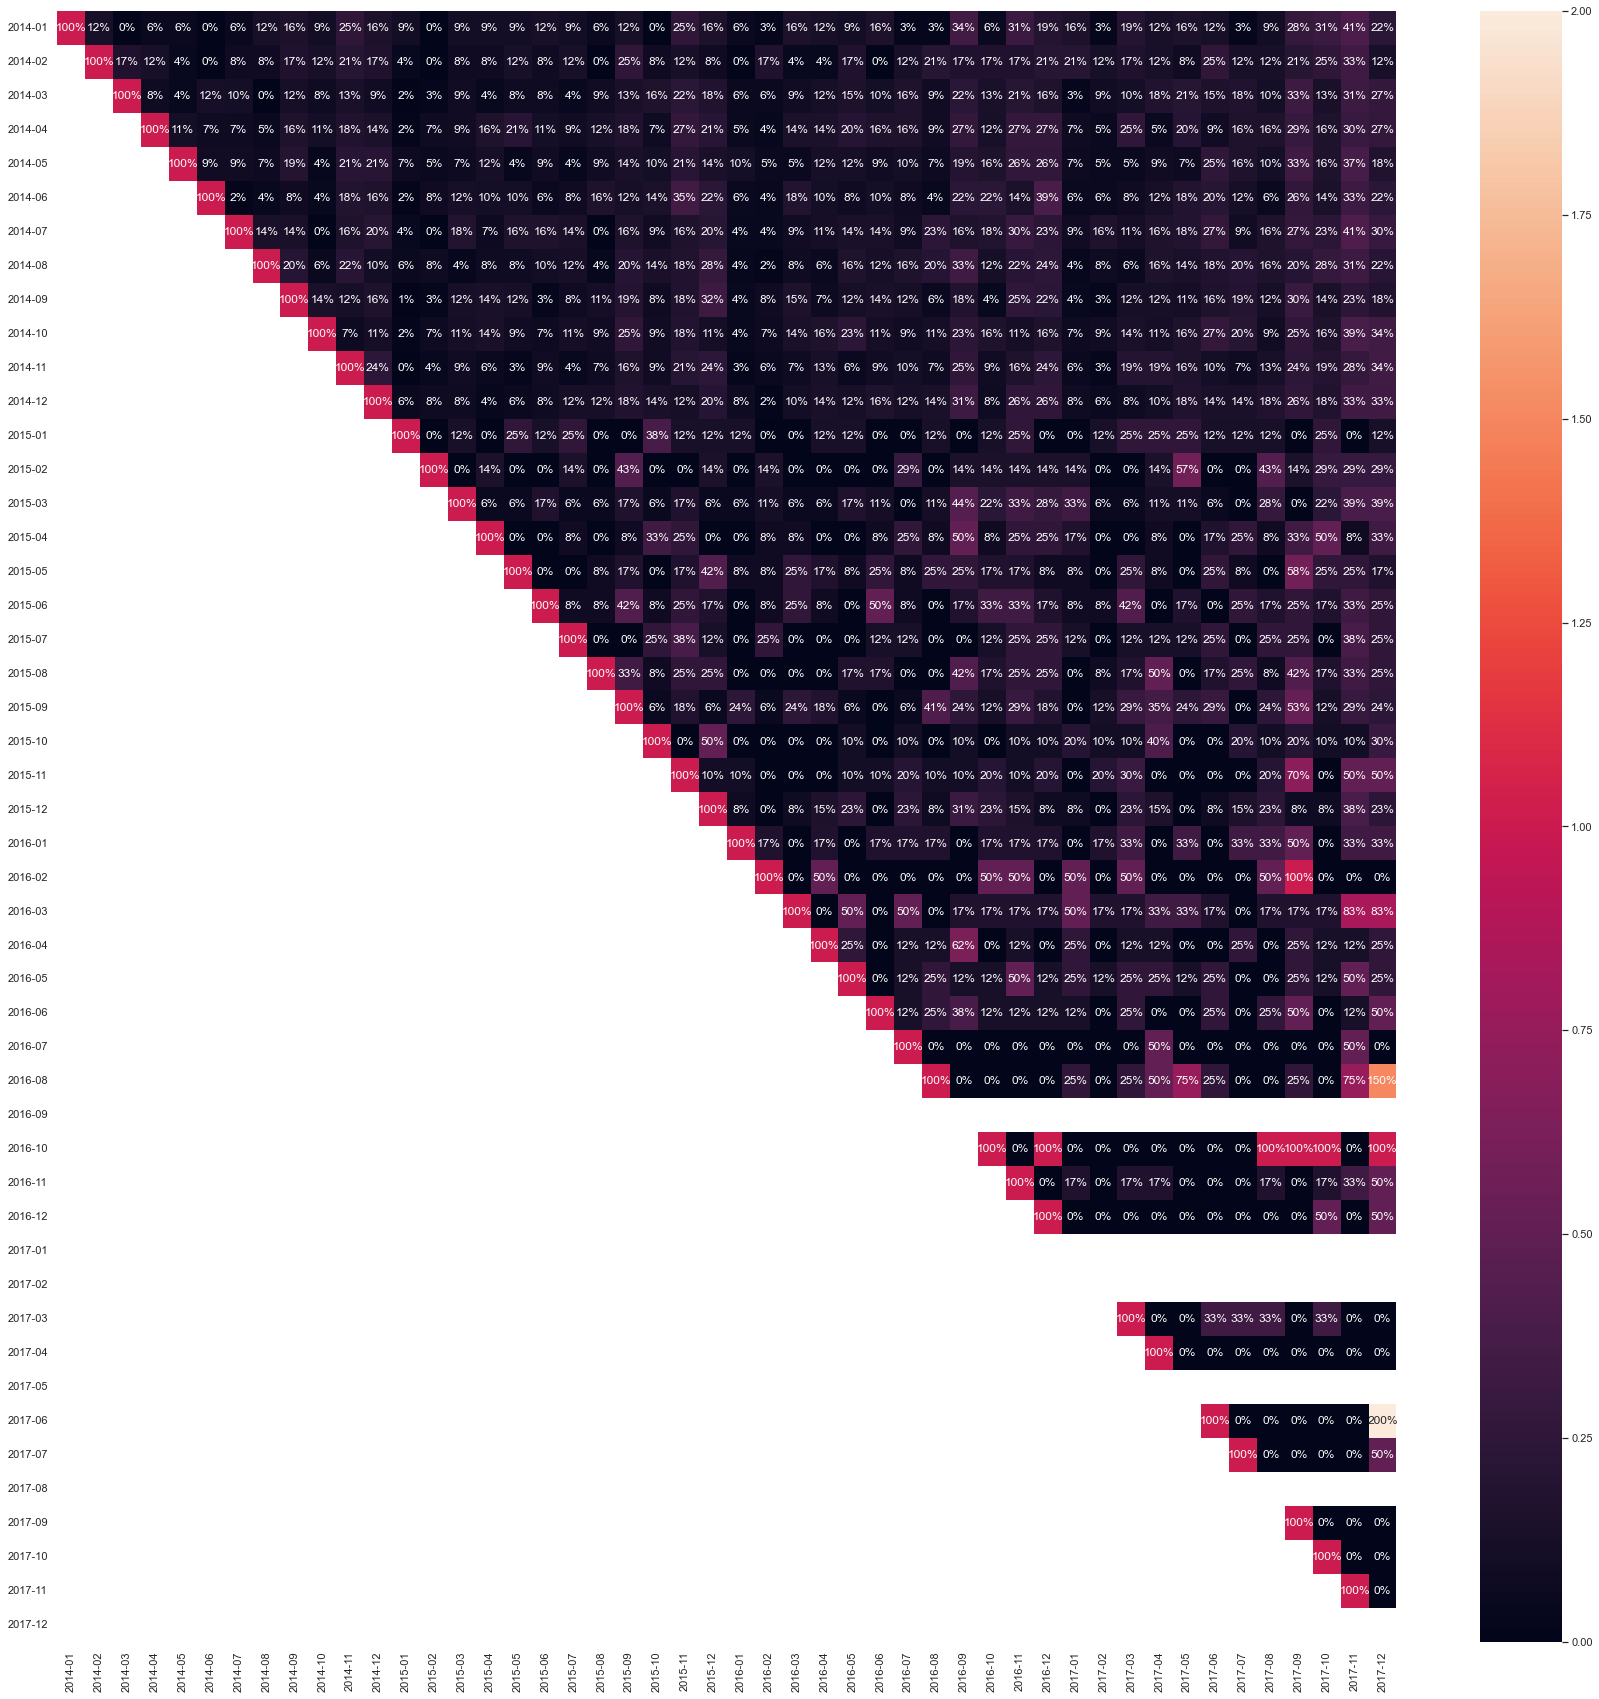

In [133]:
sns.set(style='white')
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_counts_retention.iloc[:, 2:], annot=True, fmt='.0%', yticklabels=df_counts_retention['Cohort'], ax=ax)

## Ответ

В 2017 году ретеншн хуже, чем в 2016